# **Clasificación**

In [ ]:

# Librerías
import matplotlib.pyplot as plt
import numpy as np

# MNIST

El NoteBook utilizará el conjunto de datos MNIST, que contiene 70,000 imágenes de dígitos escritos a mano, cada una etiquetada con el dígito correspondiente. Es tan conocido en Machine Learning que se le llama el "hola mundo" de este campo. Scikit-Learn facilita la descarga de conjuntos de datos populares, incluyendo MNIST. El siguiente código obtiene MNIST desde OpenML.org.

La función fetch_openml() es un poco inusual porque, por defecto, devuelve las entradas como un DataFrame de Pandas y las etiquetas como una Serie de Pandas (a menos que el conjunto de datos sea disperso). Sin embargo, como el conjunto de datos MNIST contiene imágenes, los DataFrames no son la mejor opción. Es preferible usar as_frame=False para obtener los datos como arrays de NumPy. Ahora, veamos estas matrices:

In [ ]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

El paquete sklearn.datasets ofrece tres tipos principales de funciones:

1. Funciones fetch_* como fetch_openml(), que descargan conjuntos de datos reales.
2. Funciones load_*, que cargan pequeños conjuntos de datos de prueba incluidos en Scikit-Learn (no requieren descarga).
3. Funciones make_*, que generan conjuntos de datos falsos para pruebas.

Los conjuntos de datos generados suelen devolverse como una tupla (X, y) con los datos de entrada y los objetivos en arrays de NumPy. Otros conjuntos se devuelven como objetos sklearn.utils.Bunch, que son diccionarios con entradas accesibles como atributos, y generalmente contienen las siguientes entradas:

In [ ]:
mnist.keys() 

In [ ]:
print(mnist.DESCR)

In [ ]:
X, y = mnist.data, mnist.target
X

In [ ]:
X.shape

In [ ]:
y

In [ ]:
y.shape

Hay 70,000 imágenes en el conjunto de datos, y cada una tiene 784 características. Esto es porque cada imagen tiene 28 × 28 píxeles, y cada característica representa la intensidad de un píxel, que varía de 0 (blanco) a 255 (negro). Para visualizar un dígito, tomamos el vector de características de una instancia, lo reorganizamos en una matriz de 28 × 28 y lo mostramos usando imshow() de Matplotlib, configurando cmap="binary" para mostrar en escala de grises (0 = blanco, 255 = negro).


In [ ]:
28 * 28

In [ ]:
def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")


some_digit = X[0]
plot_digit(some_digit)

plt.show()

Parece un 5, y de hecho eso es lo que nos dice la etiqueta:

In [ ]:
y[0]

Para entender mejor la complejidad de la tarea de clasificación, la figura muestra algunas imágenes adicionales del conjunto de datos MNIST. Sin embargo, es importante recordar que siempre debes crear un conjunto de prueba y reservarlo antes de analizar los datos en detalle. El conjunto de datos MNIST obtenido con fetch_openml() ya viene dividido en un conjunto de entrenamiento (las primeras 60,000 imágenes) y un conjunto de prueba (las últimas 10,000 imágenes).

In [ ]:
plt.figure(figsize=(9, 9))
for idx, image_data in enumerate(X[:100]):
    plt.subplot(10, 10, idx + 1)
    plot_digit(image_data)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

El conjunto de entrenamiento ya está barajado, lo cual es beneficioso porque asegura que todos los pliegues de cross-validation sean similares (evitando que un pliegue carezca de ciertos dígitos). Además, algunos algoritmos de aprendizaje son sensibles al orden de las instancias de entrenamiento y pueden tener un mal desempeño si se les presentan muchas instancias similares de forma consecutiva. Barajar el conjunto de datos evita este problema.

# Entrenamiento de un clasificador binario

Simplifiquemos el problema enfocándonos en identificar un solo dígito, por ejemplo, el número 5. Este "detector de 5" será un clasificador binario que distinguirá entre dos clases: 5 y no 5. Primero, crearemos los vectores objetivo específicos para esta tarea de clasificación.

In [ ]:
y_train_5 = (y_train == '5')  # Verdadero para todos los 5s, Falso para el resto de dígitos
y_test_5 = (y_test == '5')

Ahora elegiremos un clasificador y lo entrenaremos. Un buen punto de partida es un clasificador de descenso de gradiente estocástico (SGD), utilizando la clase SGDClassifier de Scikit-Learn. Este clasificador es eficiente para manejar conjuntos de datos muy grandes porque procesa cada instancia de entrenamiento de forma independiente, una por una. Esto también lo hace adecuado para el aprendizaje en línea, algo que exploraremos más adelante. Vamos a crear un SGDClassifier y entrenarlo con todo el conjunto de entrenamiento:

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

Ahora podemos utilizarlo para detectar imágenes del número 5:

In [ ]:
sgd_clf.predict([some_digit])

El clasificador adivina que esta imagen representa un 5 (Verdadero). Parece que en este caso ha acertado. Ahora, evaluemos el rendimiento de este modelo

# Performance Measures

Evaluar un clasificador es más complejo que evaluar un regresor, por lo que este NoteBook dedicará bastante tiempo a este tema. Hay muchas métricas de rendimiento disponibles, así que prepárate para aprender nuevos conceptos y acrónimos. ¡Es hora de tomar otro café!


## Medición de la precisión mediante Cross-Validation

Una buena manera de evaluar un modelo es mediante la Cross-Validation. Utilizaremos la función cross_val_score() para evaluar nuestro SGDClassifier, empleando Cross-Validation k-fold con tres folds. Esto significa que dividiremos el conjunto de entrenamiento en tres partes (folds) y entrenaremos el modelo tres veces, usando un fold diferente cada vez para la evaluación:

In [ ]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

¡Vaya! ¿Más del 95% de precisión en todos los folds de Cross-Validation? Suena increíble, ¿verdad? Pero antes de emocionarnos demasiado, consideremos un clasificador ficticio que simplemente clasifica cada imagen en la clase más frecuente, que en este caso es la clase negativa (es decir, "no 5"):

In [ ]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train)))

¿Puedes adivinar la precisión de este modelo? Averigüémoslo:

In [ ]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

Exacto, ¡tiene más del 90% de precisión! Esto ocurre porque solo alrededor del 10% de las imágenes son 5s. Por lo tanto, si siempre predices que una imagen no es un 5, acertarás aproximadamente el 90% de las veces. Mejor que Nostradamus.

Esto demuestra que la precisión no es la mejor medida de rendimiento para clasificadores, especialmente con conjuntos de datos sesgados (cuando algunas clases son mucho más frecuentes que otras). Una forma mucho mejor de evaluar el rendimiento de un clasificador es mediante la matriz de confusión (MC).

### Implementación de la validación cruzada

A veces necesitarás más control sobre el proceso de Cross-Validation del que ofrece Scikit-Learn. En estos casos, puedes implementar la Cross-Validation manualmente. El siguiente código realiza una Cross-Validation similar a la función cross_val_score() de Scikit-Learn y muestra resultados equivalentes:


In [ ]:
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold

skfolds = StratifiedKFold(n_splits=3)  # añadir shuffle=True si el conjunto de datos no esta
                                       # ya mezclado
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

La clase StratifiedKFold realiza un muestreo estratificado para asegurar que cada fold contiene una proporción representativa de cada clase. En cada iteración, el código clona el clasificador, lo entrena en los folds de entrenamiento y hace predicciones en el fold de prueba. Luego, cuenta las predicciones correctas y calcula la proporción de aciertos.

## Matriz de Confusión

La matriz de confusión cuenta cuántas veces una instancia de la clase A se clasifica como clase B, para todos los pares A/B. Por ejemplo, para ver cuántas veces el clasificador confundió imágenes de 8s con 0s, revisarías la fila #8, columna #0 de la matriz. Para calcular la matriz de confusión, primero necesitas un conjunto de predicciones para compararlas con los objetivos reales. Aunque podrías hacer predicciones en el conjunto de prueba, es mejor mantenerlo intacto hasta el final del proyecto. En su lugar, puedes usar la función cross_val_predict().

In [ ]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Al igual que la función cross_val_score(), cross_val_predict() realiza una Cross-Validation de k folds, pero en lugar de devolver las puntuaciones de evaluación, devuelve las predicciones hechas en cada pliegue de prueba. Esto significa que obtienes una predicción "limpia" para cada instancia del conjunto de entrenamiento (es decir, una predicción "fuera de muestra", donde el modelo hace predicciones sobre datos que no ha visto durante el entrenamiento). Ahora, puedes calcular la matriz de confusión utilizando la función confusion_matrix(). Simplemente pasa las clases objetivo (y_train_5) y las clases predichas (y_train_pred).

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_train_pred)
cm

Cada fila de una matriz de confusión representa una clase real, mientras que cada columna representa una clase predicha.

- Primera fila: Corresponde a las imágenes no-5 (clase negativa). De estas, 53,892 se clasificaron correctamente como no-5 (verdaderos negativos), mientras que 687 fueron clasificadas erróneamente como 5s (falsos positivos, o errores de tipo I).

- Segunda fila: Corresponde a las imágenes de 5s (clase positiva). De estas, 1,891 fueron clasificadas erróneamente como no-5 (falsos negativos, o errores de tipo II), mientras que 3,530 se clasificaron correctamente como 5s (verdaderos positivos).

Un clasificador perfecto solo tendría verdaderos positivos y verdaderos negativos, por lo que su matriz de confusión solo mostraría valores distintos de cero en la diagonal principal (de arriba a la izquierda hasta abajo a la derecha).

In [ ]:
y_train_perfect_predictions = y_train_5  # fingir que alcanzamos la perfección
confusion_matrix(y_train_5, y_train_perfect_predictions)

La matriz de confusión proporciona mucha información, pero a veces se prefiere una métrica más concisa. Una de las métricas clave es la precisión del clasificador, que mide la exactitud de las predicciones positivas:

Ecuación de Precisión:

$$ precision = \frac{TP}{TP + FP}$$ 

Donde:

- TP es el número de verdaderos positivos.
- FP es el número de falsos positivos.

Una forma sencilla de obtener una precisión perfecta sería crear un clasificador que siempre haga predicciones negativas, excepto una única predicción positiva en la que tenga más confianza. Si esa única predicción es correcta, la precisión sería del 100% (1/1 = 100%). Sin embargo, un clasificador así no sería útil, ya que ignoraría la mayoría de los casos positivos. Por eso, la precisión suele combinarse con otra métrica llamada recall (o sensibilidad o tasa de verdaderos positivos), que mide la proporción de casos positivos que el clasificador detecta correctamente.

### Ecuación de Recall:

$$ recall = \frac{TP}{TP + FN} $$

Donde:

- FN es el número de falsos negativos.

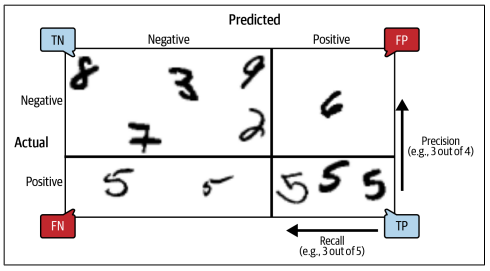

## Precision y Recall

Scikit-Learn proporciona varias funciones para calcular las métricas del clasificador, incluidas la precisión y la recuperación:

In [ ]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)  # == 3530 / (687 + 3530)

In [ ]:
# también calcula la precisión: TP / (FP + TP)
cm[1, 1] / (cm[0, 1] + cm[1, 1])

In [ ]:
recall_score(y_train_5, y_train_pred)  # == 3530 / (1891 + 3530)

In [ ]:
# esta celda también calcula el recall: TP / (FN + TP)
cm[1, 1] / (cm[1, 0] + cm[1, 1])

Ahora nuestro detector de 5 no parece tan impresionante como cuando solo consideramos su precisión. Aunque acierta el 83,7% de las veces cuando predice un 5, solo detecta el 65,1% de todos los 5s.

Para evaluar mejor el rendimiento, especialmente cuando necesitamos comparar dos clasificadores, es útil combinar la precisión y el recall en una única métrica llamada F1 Score. El F1 Score es la media armónica de la precisión y el recall. A diferencia de la media normal, que trata todos los valores por igual, la media armónica da más peso a los valores bajos. Por lo tanto, el F1 Score solo será alto si tanto la precisión como el recall son altos.

Ecuación F1 Score
$$ F1 = \frac{2}{\frac{1}{precisión}+\frac{1}{recall}} = 2 \times \frac{precision × recall}{precision + recall} = \frac{TP}{TP+\frac{FN+FP}{2}}


Para calcular el F1 Score, basta con llamar a la función f1_score():

In [ ]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

In [ ]:
# esta celda también calcula la puntuación f1
cm[1, 1] / (cm[1, 1] + (cm[1, 0] + cm[0, 1]) / 2)

El F1 Score favorece a los clasificadores que mantienen un equilibrio entre precisión y recall. Sin embargo, en algunos contextos, este equilibrio no es lo más deseable. A veces, se prefiere priorizar la precisión o el recall según la situación:

- Alta precisión: Imagina que entrenas un clasificador para detectar videos seguros para niños. En este caso, podrías preferir un clasificador que rechace muchos videos buenos (bajo recall) pero que asegure que solo se mantengan los videos seguros (alta precisión). Esto evitaría que cualquier contenido inapropiado llegue a los niños, aunque se pierdan algunos videos buenos.

- Alto recall: Por otro lado, si estás entrenando un clasificador para detectar ladrones en imágenes de vigilancia, podrías aceptar un clasificador con solo un 30% de precisión siempre que tenga un 99% de recall. Esto significa que, aunque haya muchas alertas falsas, casi todos los ladrones serían capturados, lo que es crucial en este contexto.

Lamentablemente, no se puede maximizar ambas métricas al mismo tiempo: mejorar la precisión generalmente reduce el recall, y viceversa. Este es el trueque precisión/recall.

## Precision/Recall Trade-off o Compensación

Para entender el equilibrio entre precisión y recall, veamos cómo el SGDClassifier toma sus decisiones de clasificación. Para cada instancia, calcula una puntuación basada en una función de decisión. Si la puntuación supera un cierto umbral, asigna la instancia a la clase positiva; si no, la asigna a la clase negativa.

Imagina una serie de dígitos ordenados desde la puntuación más baja a la izquierda hasta la más alta a la derecha. Supongamos que el umbral de decisión se sitúa en la flecha central, entre dos imágenes de 5. Con ese umbral, el clasificador identifica correctamente 4 de los 5 reales como verdaderos positivos, pero también clasifica erróneamente un 6 como positivo, resultando en 1 falso positivo. Así, la precisión es del 80% (4 de 5), pero la recall es del 67% (4 de 6).

- Aumentar el umbral: Si el umbral se mueve hacia la derecha, el falso positivo (el 6) se convierte en un verdadero negativo, lo que mejora la precisión (hasta el 100% en este caso). Sin embargo, uno de los verdaderos positivos ahora se convierte en un falso negativo, reduciendo la recall al 50%.

- Reducir el umbral: Si se reduce el umbral, se capturan más verdaderos positivos, aumentando la recall, pero también se introducen más falsos positivos, lo que reduce la precisión.

Este ejemplo ilustra cómo ajustar el umbral afecta directamente el equilibrio entre precisión y recall.

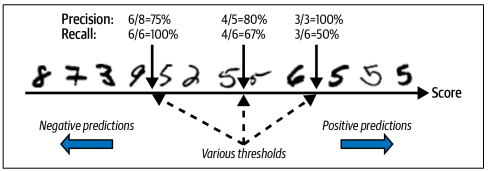

Scikit-Learn no permite establecer el umbral directamente, pero te da acceso a las puntuaciones de decisión que el clasificador utiliza para hacer predicciones. En lugar de usar el método predict() del clasificador, puedes llamar al método decision_function(), que devuelve una puntuación para cada instancia. Luego, puedes aplicar cualquier umbral que desees a esas puntuaciones para hacer tus propias predicciones.

In [ ]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

In [ ]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [ ]:
y_some_digit_pred

In [ ]:
# sólo muestra que y_scores > 0 produce el mismo resultado que
# llamando a predict()
y_scores > 0

El SGDClassifier utiliza un umbral igual a 0, por lo que el código anterior devuelve el mismo resultado que el método predict() (es decir, True). Aumentemos el umbral:

In [ ]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

Esto confirma que el aumento del umbral disminuye la recuperación. La imagen representa realmente un 5, y el clasificador lo detecta cuando el umbral es 0, pero no lo detecta cuando el umbral aumenta a 3.000.

¿Cómo se decide qué umbral utilizar? En primer lugar, utilice la función cross_val_predict() para obtener las puntuaciones de todas las instancias del conjunto de entrenamiento, pero esta vez especifique que desea devolver puntuaciones de decisión en lugar de predicciones:

In [ ]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

Con estas puntuaciones, utilice la función precision_recall_curve() para calcular la precisión y la recall para todos los umbrales posibles (la función añade una última precisión de 0 y una última recall de 1, lo que corresponde a un umbral infinito):

In [ ]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Por último, utilice Matplotlib para representar gráficamente la precisión y la recall en función del valor del umbral. Vamos a mostrar el umbral de 3.000 que hemos seleccionado:

In [ ]:
plt.figure(figsize=(8, 4))  
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")


idx = (thresholds >= threshold).argmax()  # primer índice ≥ umbral
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")

plt.show()

En la gráfica, parece que el umbral óptimo se encuentra cerca de cero, donde las líneas de precisión y recall se cruzan o están más cercanas. Este punto suele representar un buen equilibrio entre precisión y recall. Sin embargo, el umbral óptimo final puede variar dependiendo del costo relativo de los falsos positivos y falsos negativos en la aplicación específica en la que se utilice el clasificador.


Puede que te preguntes por qué la curva de precisión es más irregular que la curva de recall. Esto se debe a que, aunque la precisión generalmente aumenta con el umbral, a veces puede disminuir. Para entenderlo, observa lo que ocurre cuando se parte del umbral central y se mueve un dígito a la derecha: la precisión baja de 4/5 (80%) a 3/4 (75%). Por otro lado, el recall solo puede disminuir al aumentar el umbral, lo que explica por qué su curva es más suave.

Con este umbral, la precisión se aproxima al 90%, mientras que el recall cae al 50%. Otra manera de elegir un buen equilibrio entre precisión y recall es trazando una gráfica de precisión frente a recall, como se muestra en la Figura (con el mismo umbral marcado).

In [ ]:
import matplotlib.patches as patches

plt.figure(figsize=(6, 5))  

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 3,000")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")

plt.show()

Puedes observar que la precisión empieza a caer bruscamente alrededor del 80% de recall. Es probable que quieras elegir un punto de equilibrio entre precisión y recall justo antes de esa caída, por ejemplo, cerca del 60% de recall. Sin embargo, la elección dependerá de los objetivos de tu proyecto. Supongamos que decides alcanzar una precisión del 90%. Podrías usar el primer gráfico para encontrar el umbral necesario, pero no sería muy preciso. Alternativamente, puedes buscar el umbral más bajo que te proporcione al menos un 90% de precisión. Para esto, puedes utilizar el método argmax() de NumPy, que devuelve el primer índice del valor máximo, lo que en este caso sería el primer valor verdadero que cumple con la condición deseada:

In [ ]:
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

Para hacer predicciones (en el conjunto de entrenamiento por ahora), en lugar de llamar al método predict() del clasificador, puedes ejecutar este código:

In [ ]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

Let’s check these predictions’ precision and recall:

In [ ]:
precision_score(y_train_5, y_train_pred_90)

In [ ]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

¡Genial, has logrado un clasificador con un 90% de precisión! Sin embargo, como puedes ver, es relativamente fácil crear un clasificador con casi cualquier precisión deseada simplemente estableciendo un umbral lo suficientemente alto. Pero, espera, no tan rápido: un clasificador con alta precisión no es muy útil si su recall es demasiado baja. En muchas aplicaciones, un 48% de recall sería insuficiente.

Si alguien dice: "Alcancemos una precisión del 99%", hay que preguntar: "¿Con qué recall?".

## The ROC Curve

La curva Receiver Operating Characteristic (ROC) es otra herramienta comúnmente utilizada con clasificadores binarios. Es similar a la curva de precisión/recall, pero en lugar de representar la precisión frente a la recall, la curva ROC muestra la tasa de verdaderos positivos (TPR), que es otro nombre para la recall, frente a la tasa de falsos positivos (FPR).

El FPR (también llamado fall-out) es la proporción de instancias negativas que se clasifican incorrectamente como positivas. Se calcula como $1−TNR$, donde TNR es la tasa de verdaderos negativos, es decir, la proporción de casos negativos que se clasifican correctamente como negativos. La TNR también se conoce como especificidad. Por lo tanto, la curva ROC representa la sensibilidad (recall) frente a $1−especificidad$

Para trazar la curva ROC, primero utilizamos la función roc_curve() para calcular el TPR y el FPR para varios valores de umbral:


In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

A continuación, puedes trazar el FPR contra el TPR utilizando Matplotlib. El siguiente código generará el gráfico de la Figura. Para identificar el punto que corresponde al 90% de precisión, es necesario buscar el índice del umbral deseado. Como en este caso los umbrales están ordenados en orden decreciente, utilizamos <= en lugar de >= en la primera línea:

In [ ]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(6, 5))  # código extra - no es necesario, sólo formateo
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

# código extra - sólo embellece y ahorra Figura 3-7
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)

plt.show()


Una vez más, hay una compensación: cuanto mayor es la recall (TPR), más falsos positivos (FPR) genera el clasificador. La línea de puntos en la gráfica representa la curva ROC de un clasificador puramente aleatorio; un buen clasificador se mantendrá lo más alejado posible de esa línea (hacia la esquina superior izquierda).

Una forma de comparar clasificadores es medir el área bajo la curva (AUC). Un clasificador perfecto tendrá un $AUC , ROC = 1$, mientras que un clasificador puramente aleatorio tendrá un $AUC , ROC = 0.5$. Scikit-Learn proporciona una función para estimar el $AUC , ROC$:

In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

Dado que la curva ROC es tan similar a la curva de precisión/recall (PR), puede que te preguntes cuál utilizar. Como regla general, deberías preferir la curva PR cuando la clase positiva sea poco frecuente o cuando te preocupen más los falsos positivos que los falsos negativos. En otros casos, utiliza la curva ROC.

Por ejemplo, al observar la curva ROC anterior (y la puntuación $AUC , ROC$), podrías pensar que el clasificador es muy bueno. Sin embargo, esto se debe en gran parte a que hay pocos positivos (5s) en comparación con los negativos (no-5s). En cambio, la curva PR muestra que el clasificador aún tiene margen de mejora: la curva podría estar mucho más cerca de la esquina superior derecha (como se muestra en la Figura 3-6).

Creemos ahora un RandomForestClassifier, cuya curva PR y el F1 Score podemos comparar con los del SGDClassifier:

**Atención:** la siguiente celda puede tardar unos minutos en ejecutarse.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

La función precision_recall_curve() espera etiquetas y puntuaciones para cada instancia, por lo que necesitamos entrenar al clasificador de Random Forest y obtener una puntuación para cada instancia. Sin embargo, la clase RandomForestClassifier no tiene un método decision_function() debido a su funcionamiento. Afortunadamente, tiene un método predict_proba() que devuelve las probabilidades de clase para cada instancia. Podemos usar la probabilidad de la clase positiva como puntuación, lo cual funcionará bien.

Podemos utilizar la función cross_val_predict() para entrenar el RandomForestClassifier con Cross-Validation y hacer que prediga las probabilidades de clase para cada imagen de la siguiente manera:


In [ ]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

Veamos las probabilidades de clase de las dos primeras imágenes del conjunto de entrenamiento:

In [ ]:
y_probas_forest[:2]

El modelo predice que la primera imagen es positiva con un 89% de probabilidad, y predice que la segunda imagen es negativa con un 99% de probabilidad. Como cada imagen es positiva o negativa, las probabilidades de cada fila suman 100%.

Estas son probabilidades estimadas, no reales. Por ejemplo, si observas todas las imágenes que el modelo clasificó como positivas con una probabilidad estimada entre el 50% y el 60%, aproximadamente el 94% de ellas son realmente positivas. Esto indica que las probabilidades estimadas del modelo eran demasiado bajas en este caso, aunque también puede suceder que los modelos sean demasiado confiados.

El paquete sklearn.calibration contiene herramientas para calibrar las probabilidades estimadas y acercarlas mucho más a las probabilidades reales. Para más detalles, consulta la sección de material extra.

In [ ]:
idx_50_to_60 = (y_probas_forest[:, 1] > 0.50) & (y_probas_forest[:, 1] < 0.60)
print(f"{(y_train_5[idx_50_to_60]).sum() / idx_50_to_60.sum():.1%}")

La segunda columna contiene las probabilidades estimadas para la clase positiva, así que pasémoslas a la función precision_recall_curve():

In [ ]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(
    y_train_5, y_scores_forest)

Ahora estamos listos para trazar la curva PR. Es útil trazar también la primera curva PR para ver cómo se comparan:

In [ ]:
plt.figure(figsize=(6, 5)) 

plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2,
         label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")

plt.show()

Como puede verse en la Figura, la curva PR del RandomForestClassifier tiene mucho mejor aspecto que la del SGDClassifier: se acerca mucho más a la esquina superior derecha. Su F1 Score y su puntuación ROC AUC también son significativamente mejores:

Podríamos utilizar `cross_val_predict(forest_clf, X_train, y_train_5, cv=3)` para calcular `y_train_pred_forest`, pero como ya tenemos las probabilidades estimadas, podemos utilizar el umbral por defecto del 50% de probabilidad para obtener las mismas predicciones mucho más rápido:

In [ ]:
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5  # probabilidad positiva ≥ 50%
f1_score(y_train_5, y_train_pred_forest)

In [ ]:
roc_auc_score(y_train_5, y_scores_forest)

In [ ]:
precision_score(y_train_5, y_train_pred_forest)

In [ ]:
recall_score(y_train_5, y_train_pred_forest)


Prueba a medir las puntuaciones de precisión y recall: deberías obtener aproximadamente un 99,1% de precisión y un 86,6% de recall. Nada mal. Ahora ya sabes cómo entrenar clasificadores binarios, elegir la métrica adecuada para tu tarea, evaluar los clasificadores mediante Cross-Validation, seleccionar el equilibrio precisión/recall que mejor se ajuste a tus necesidades, y utilizar varias métricas y curvas para comparar diferentes modelos. ¡Ya estás listo para intentar detectar algo más que los 5s!

# Clasificación Multiclase 

Mientras que los clasificadores binarios distinguen entre dos clases, los clasificadores multiclase (o multinomiales) pueden distinguir entre más de dos clases.

Algunos clasificadores en Scikit-Learn, como LogisticRegression, RandomForestClassifier y GaussianNB, manejan múltiples clases de manera nativa. Otros, como SGDClassifier y SVC, son estrictamente binarios. Sin embargo, hay estrategias que permiten realizar la clasificación multiclase usando clasificadores binarios:

1. Estrategia OvR (uno contra el resto): Consiste en entrenar 10 clasificadores binarios, uno para cada dígito (0, 1, 2, etc.). Para clasificar una imagen, se obtiene la puntuación de decisión de cada clasificador y se elige la clase con la puntuación más alta.

2. Estrategia OvO (uno contra uno): Consiste en entrenar un clasificador binario para cada par de dígitos, lo que requiere entrenar $N \times (N - 1) / 2$ clasificadores. En el caso de MNIST, esto significa entrenar 45 clasificadores. Para clasificar una imagen, se la pasa por los 45 clasificadores y se elige la clase que gana más "duelos". OvO es útil para algoritmos que no escalan bien con el tamaño del conjunto de entrenamiento, como las SVMs.

Scikit-Learn detecta automáticamente si se está usando un algoritmo binario para una tarea multiclase y aplica OvR u OvO según el caso. Vamos a probar esto con un clasificador SVM (sklearn.svm.SVC), entrenando solo con las primeras 2,000 imágenes para ahorrar tiempo:

Los SVM no se adaptan bien a grandes conjuntos de datos, así que vamos a entrenar sólo las primeras 2.000 instancias, o de lo contrario esta sección tardará mucho tiempo en ejecutarse:

In [ ]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])

Ha sido sencillo. Entrenamos el SVC utilizando las clases objetivo originales de 0 a 9 (y_train), en lugar de las clases objetivo de 5 contra el resto (y_train_5). Dado que hay 10 clases (más de 2), Scikit-Learn utilizó la estrategia OvO y entrenó 45 clasificadores binarios. Ahora, vamos a hacer una predicción sobre una imagen:

In [ ]:
svm_clf.predict([some_digit])

Correcto. Este código realizó en realidad 45 predicciones, una por cada par de clases, y luego seleccionó la clase que ganó más duelos. Si llamas al método decision_function(), verás que devuelve 10 puntuaciones por instancia: una para cada clase. Cada clase recibe una puntuación que corresponde al número de duelos ganados, con un pequeño ajuste (máximo ±0,33) para romper empates, basado en las puntuaciones del clasificador:

In [ ]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores.round(2)

La puntuación más alta es 9,3, y es efectivamente la correspondiente a la clase 5:

In [ ]:
class_id = some_digit_scores.argmax()
class_id

Cuando entrenas un clasificador, este almacena la lista de clases objetivo en su atributo classes_, ordenadas por valor. En el caso de MNIST, el índice de cada clase en la matriz classes_ coincide convenientemente con la clase en sí (por ejemplo, la clase en el índice 5 corresponde a la clase '5'). Sin embargo, en general, es posible que no tengas tanta suerte, por lo que necesitarás buscar la etiqueta de la clase de la siguiente manera:

In [ ]:
svm_clf.classes_

In [ ]:
svm_clf.classes_[class_id]

Si quieres forzar a Scikit-Learn a usar la estrategia uno contra uno (OvO) o uno contra el resto (OvR), puedes usar las clases OneVsOneClassifier o OneVsRestClassifier. Solo necesitas crear una instancia y pasar un clasificador a su constructor (ni siquiera tiene que ser un clasificador binario). Por ejemplo, el siguiente código crea un clasificador multiclase utilizando la estrategia OvR, basado en un SVC:

Si deseas que decision_function() devuelva los 45 puntajes, puedes establecer el hiperparámetro decision_function_shape en "ovo". Aunque el valor predeterminado es "ovr", no te dejes confundir: SVC siempre utiliza OvO para el entrenamiento. Este hiperparámetro solo afecta si los 45 puntajes se agregan o no.


In [ ]:
# muestra cómo obtener las 45 puntuaciones OvO si es necesario
svm_clf.decision_function_shape = "ovo"
some_digit_scores_ovo = svm_clf.decision_function([some_digit])
some_digit_scores_ovo.round(2)

In [ ]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

In [ ]:
ovr_clf.predict([some_digit])

In [ ]:
len(ovr_clf.estimators_)

Entrenar un SGDClassifier en un conjunto de datos multiclase y utilizarlo para realizar predicciones es igual de sencillo

In [ ]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

¡Tienes razón! Me equivoqué. En realidad, cuando SVC utiliza la estrategia OvR, entrena 10 clasificadores binarios (uno por cada clase). El método decision_function() devuelve un valor por clase. Ahora, veamos las puntuaciones que el clasificador SGD asignó a cada clase:

In [ ]:
sgd_clf.decision_function([some_digit]).round()


Puedes observar que el clasificador no tiene mucha confianza en su predicción: casi todas las puntuaciones son muy negativas, con la clase 3 alcanzando una puntuación de +1.824, y la clase 5 no muy lejos con -1.386. Por supuesto, querrás evaluar este clasificador en más de una imagen. Dado que hay aproximadamente el mismo número de imágenes en cada clase, la métrica de precisión es adecuada. Como de costumbre, puedes usar la función cross_val_score() para evaluar el modelo:

**Atención:** las dos celdas siguientes pueden tardar unos minutos cada una en ejecutarse:

In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

Obtiene más del 85,8% en todos los folds de prueba. Si utilizara un clasificador aleatorio, obtendría una precisión del 10%, por lo que no es una puntuación tan mala, pero aún puede hacerlo mucho mejor. Simplemente escalando las entradas aumenta la precisión por encima del 89,1%:


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

# Análisis de errores

En un proyecto real, después de seguir tu lista de comprobación de Machine Learning, explorarías opciones de preparación de datos, probarías varios modelos, preseleccionarías los mejores, ajustarías sus hiperparámetros con GridSearchCV, y automatizarías todo lo posible. Suponiendo que has encontrado un modelo prometedor y deseas mejorarlo, una forma de hacerlo es analizar los tipos de errores que comete.

Primero, debes observar la matriz de confusión. Para esto, necesitas hacer predicciones usando cross_val_predict() y luego pasar las etiquetas y predicciones a la función confusion_matrix(), tal como lo hiciste antes. Sin embargo, como ahora hay 10 clases en lugar de 2, la matriz de confusión contendrá muchos números, lo que puede ser difícil de interpretar. Un diagrama coloreado de la matriz de confusión es mucho más fácil de analizar.

Para trazar dicho diagrama, puedes usar la función ConfusionMatrixDisplay.from_predictions() de la siguiente manera:

**Atención:** la siguiente celda tardará unos minutos en ejecutarse:

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
plt.rc('font', size=9)  # código extra - hacer el texto más pequeño
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.show()


Esto genera el diagrama de la izquierda en la Figura. La matriz de confusión se ve bastante bien: la mayoría de las imágenes están en la diagonal principal, lo que indica que fueron clasificadas correctamente. Sin embargo, la celda en la diagonal de la fila #5 y columna #5 parece ligeramente más oscura que las de otros dígitos. Esto podría indicar que el modelo cometió más errores en los 5s, o simplemente que hay menos 5s en el conjunto de datos en comparación con otros dígitos.

Para obtener una visión más clara, es importante normalizar la matriz de confusión dividiendo cada valor por el número total de imágenes en la clase verdadera correspondiente (es decir, dividiendo por la suma de la fila). Esto se puede lograr estableciendo normalize="true". Además, puedes especificar el argumento values_format=".0%" para mostrar los porcentajes sin decimales. El siguiente código genera el diagrama de la derecha en la Figura:


In [ ]:
plt.rc('font', size=10)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        normalize="true", values_format=".0%")
plt.show()

Ahora podemos ver claramente que solo el 82% de las imágenes de 5s se clasificaron correctamente. El error más común que cometió el modelo con las imágenes de 5 fue clasificarlas erróneamente como 8, lo que ocurrió con el 10% de todas las imágenes de 5. Sin embargo, solo el 2% de las imágenes de 8 se clasificaron erróneamente como 5. Las matrices de confusión generalmente no son simétricas.

Si observas con atención, verás que muchos dígitos se clasificaron erróneamente como 8, pero esto no es evidente en el diagrama actual. Para hacer que los errores destaquen más, puedes intentar asignar un peso cero a las predicciones correctas. El siguiente código hace exactamente eso y produce el diagrama de la izquierda en la Figura:


In [ ]:
sample_weight = (y_train_pred != y_train)
plt.rc('font', size=10) 
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred,
                                        sample_weight=sample_weight,
                                        normalize="true", values_format=".0%")
plt.show()

Pongamos todas las tramas en un par de cifras para el libro:

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
plt.rc('font', size=9)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[0])
axs[0].set_title("Confusion matrix")
plt.rc('font', size=10)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[1],
                                        normalize="true", values_format=".0%")
axs[1].set_title("CM normalized by row")

plt.show()

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
plt.rc('font', size=10)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[0],
                                        sample_weight=sample_weight,
                                        normalize="true", values_format=".0%")
axs[0].set_title("Errors normalized by row")
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[1],
                                        sample_weight=sample_weight,
                                        normalize="pred", values_format=".0%")
axs[1].set_title("Errors normalized by column")

plt.show()
plt.rc('font', size=14)

Ahora, puedes ver con mucha más claridad los tipos de errores que comete el clasificador. La columna correspondiente a la clase 8 es ahora muy destacada, lo que confirma que muchas imágenes se clasificaron erróneamente como 8s. De hecho, este es el error de clasificación más común para casi todas las clases. Sin embargo, es importante ser cauteloso al interpretar los porcentajes en este diagrama, ya que hemos excluido las predicciones correctas. Por ejemplo, cuando se dice que el 36% de la fila 7, columna 9, se refiere a errores, no significa que el 36% de todas las imágenes de 7 se clasificaron erróneamente como 9. Significa que el 36% de los errores cometidos con imágenes de 7 fueron clasificaciones erróneas como 9. En realidad, solo el 3% de las imágenes de 7 fueron clasificadas como 9, como se puede ver en el diagrama de la derecha de la Figura.

También es posible normalizar la matriz de confusión por columnas en lugar de por filas: si se establece normalize="pred", se obtiene el diagrama de la derecha de la Figura. Por ejemplo, se puede ver que el 56% de los 7 mal clasificados son en realidad 9s.

El análisis de la matriz de confusión a menudo proporciona ideas sobre cómo mejorar tu clasificador. Al observar estos gráficos, parece que deberías enfocarte en reducir los errores en la clasificación de los 8s. Por ejemplo, podrías intentar recopilar más datos de entrenamiento de dígitos que se parecen a un 8 (pero que no lo son) para que el clasificador pueda aprender a distinguirlos de los 8 reales. También podrías diseñar nuevas características para ayudar al clasificador, como un algoritmo que cuente el número de bucles cerrados (por ejemplo, 8 tiene dos, 6 tiene uno, 5 no tiene ninguno). O podrías preprocesar las imágenes (usando herramientas como Scikit-Image, Pillow o OpenCV) para resaltar ciertos patrones, como los bucles cerrados.

El análisis de errores individuales también puede proporcionar valiosa información sobre lo que está haciendo el clasificador y por qué falla. Por ejemplo, podrías trazar ejemplos de 3s y 5s en un estilo de matriz de confusión para examinar más de cerca esos errores específicos.

In [ ]:
cl_a, cl_b = '3', '5'
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

In [ ]:
size = 5
pad = 0.2
plt.figure(figsize=(size, size))
for images, (label_col, label_row) in [(X_ba, (0, 0)), (X_bb, (1, 0)),
                                       (X_aa, (0, 1)), (X_ab, (1, 1))]:
    for idx, image_data in enumerate(images[:size*size]):
        x = idx % size + label_col * (size + pad)
        y = idx // size + label_row * (size + pad)
        plt.imshow(image_data.reshape(28, 28), cmap="binary",
                   extent=(x, x + 1, y, y + 1))
plt.xticks([size / 2, size + pad + size / 2], [str(cl_a), str(cl_b)])
plt.yticks([size / 2, size + pad + size / 2], [str(cl_b), str(cl_a)])
plt.plot([size + pad / 2, size + pad / 2], [0, 2 * size + pad], "k:")
plt.plot([0, 2 * size + pad], [size + pad / 2, size + pad / 2], "k:")
plt.axis([0, 2 * size + pad, 0, 2 * size + pad])
plt.xlabel("Predicted label")
plt.ylabel("True label")

plt.show()

Como puedes ver, algunos de los dígitos que el clasificador clasifica incorrectamente (en los bloques inferior izquierdo y superior derecho) están tan mal escritos que incluso un humano tendría problemas para identificarlos correctamente. Sin embargo, la mayoría de las imágenes mal clasificadas parecen errores obvios. Puede resultar difícil entender por qué el clasificador cometió esos errores, pero hay que recordar que el cerebro humano es un sistema de reconocimiento de patrones extremadamente avanzado, y nuestro sistema visual realiza un preprocesamiento complejo antes de que la información llegue a nuestra conciencia. Por lo tanto, que esta tarea parezca sencilla para nosotros no significa que lo sea.

Recuerda que estamos utilizando un simple SGDClassifier, que es un modelo lineal: básicamente, asigna un peso a cada píxel por clase y, cuando ve una nueva imagen, suma las intensidades ponderadas de los píxeles para obtener una puntuación para cada clase. Dado que los 3s y 5s solo difieren en unos pocos píxeles, este modelo puede confundirlos fácilmente.

La principal diferencia entre un 3 y un 5 es la posición de la pequeña línea que une la parte superior con el arco inferior. Si dibujas un 3 con la unión ligeramente desplazada hacia la izquierda, el clasificador podría clasificarlo como un 5, y viceversa. En otras palabras, este clasificador es bastante sensible al desplazamiento y la rotación de la imagen.

Una forma de reducir la confusión entre 3 y 5 es preprocesar las imágenes para asegurarse de que están bien centradas y no demasiado rotadas. Sin embargo, esto puede ser complicado, ya que requiere predecir la rotación correcta de cada imagen. Un enfoque más sencillo es aumentar el conjunto de entrenamiento con variantes ligeramente desplazadas y rotadas de las imágenes de entrenamiento. Esto obligará al modelo a aprender a ser más tolerante a estas variaciones, una técnica conocida como aumento de datos.

# Clasificación Multilabel

Hasta ahora, cada instancia se ha asignado siempre a una sola clase. Sin embargo, en algunos casos, es posible que desees que tu clasificador emita varias clases para cada instancia. Por ejemplo, en un clasificador de reconocimiento facial, ¿qué debería hacer si reconoce a varias personas en la misma foto? Debería asignar una etiqueta a cada persona que reconozca.

Supongamos que el clasificador ha sido entrenado para reconocer tres rostros: Alicia, Bob y Charlie. Si se le muestra una imagen en la que aparecen Alicia y Charlie, el resultado debería ser [Verdadero, Falso, Verdadero] (lo que significa "Alicia sí, Bob no, Charlie sí"). Un sistema de clasificación que produce múltiples etiquetas binarias se denomina sistema de clasificación multietiqueta.

Aunque no entraremos en el reconocimiento facial por ahora, veamos un ejemplo más sencillo para ilustrar cómo funciona:

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= '7')
y_train_odd = (y_train.astype('int8') % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

Este código crea una matriz y_multilabel que contiene dos etiquetas objetivo para cada imagen de dígito:

1. La primera etiqueta indica si el dígito es grande (7, 8 o 9).
2. La segunda etiqueta indica si el dígito es impar.

Luego, el código crea una instancia de KNeighborsClassifier, que admite la clasificación multietiqueta (a diferencia de otros clasificadores que no la soportan), y entrena este modelo utilizando la matriz de objetivos múltiples. Ahora puedes hacer una predicción y observar que el clasificador emite dos etiquetas:

1. Una para si el dígito es grande.
2. Otra para si es impar.


In [ ]:
knn_clf.predict([some_digit])

¡Y acierta! Efectivamente, el dígito 5 no es grande (Falso) y es impar (Verdadero).

Existen muchas formas de evaluar un clasificador multietiqueta, y la elección de la métrica adecuada depende del proyecto específico. Un enfoque común es calcular el F1 Score para cada etiqueta individual (o cualquier otra métrica de clasificación binaria discutida anteriormente) y luego promediar estas puntuaciones.

El siguiente código ilustra cómo calcular la puntuación F1 media de todas las etiquetas:

**Atención**: la siguiente célula puede tardar unos minutos en ejecutarse:

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

In [ ]:
# muestra que obtenemos una mejora de rendimiento insignificante cuando
#establecemos average="weighted" porque las clases ya están bastante bien equilibradas.

f1_score(y_multilabel, y_train_knn_pred, average="weighted")

Este enfoque asume que todas las etiquetas tienen la misma importancia, lo cual puede no ser el caso. Por ejemplo, si tienes muchas más fotos de Alicia que de Bob o Charlie, podrías querer dar más peso a la precisión del clasificador en las fotos de Alicia. Una manera sencilla de hacer esto es ponderar cada etiqueta según su soporte (es decir, el número de instancias con esa etiqueta objetivo). Para lograrlo, simplemente puedes establecer average="weighted" al llamar a la función f1_score().

Si deseas utilizar un clasificador que no admite de forma nativa la clasificación multietiqueta, como SVC, una posible estrategia es entrenar un modelo por cada etiqueta. Sin embargo, esta estrategia podría tener dificultades para capturar las dependencias entre las etiquetas. Por ejemplo, un dígito grande (7, 8 o 9) tiene más probabilidades de ser par que impar, pero el clasificador para la etiqueta "impar" no tiene en cuenta lo que predijo el clasificador para la etiqueta "grande".

Para abordar este problema, los modelos pueden organizarse en una cadena: cuando un modelo hace una predicción, utiliza las características de entrada junto con todas las predicciones de los modelos anteriores en la cadena.

La buena noticia es que Scikit-Learn tiene una clase llamada ChainClassifier que hace precisamente eso. Por defecto, utilizará las etiquetas verdaderas para el entrenamiento, alimentando cada modelo con las etiquetas adecuadas según su posición en la cadena. Sin embargo, si configuras el hiperparámetro cv, se usará la validación cruzada para obtener predicciones "limpias" (fuera de muestra) de cada modelo entrenado para cada instancia del conjunto de entrenamiento, y estas predicciones se utilizarán para entrenar todos los modelos posteriores en la cadena.

A continuación, un ejemplo que muestra cómo crear y entrenar un ChainClassifier utilizando la estrategia de validación cruzada. Como antes, solo utilizaremos las primeras 2,000 imágenes del conjunto de entrenamiento para acelerar el proceso:

In [ ]:
from sklearn.multioutput import ClassifierChain

chain_clf = ClassifierChain(SVC(), cv=3, random_state=42)
chain_clf.fit(X_train[:2000], y_multilabel[:2000])

In [ ]:
chain_clf.predict([some_digit])

# Clasificación Multioutput

El último tipo de tarea de clasificación que veremos es la clasificación multisalida-multiclase (o simplemente clasificación multisalida). Es una extensión de la clasificación multietiqueta donde cada etiqueta puede tener múltiples valores posibles.

Para ilustrarlo, imaginemos un sistema que elimina el ruido de las imágenes. Este sistema toma una imagen ruidosa como entrada y genera una imagen limpia como salida, representada por una matriz de intensidades de píxeles, similar a las imágenes MNIST. Aquí, la salida es multietiqueta (una etiqueta por píxel), y cada etiqueta puede tener varios valores (la intensidad del píxel entre 0 y 255), lo que hace de este un ejemplo de clasificación multisalida.

La distinción entre clasificación y regresión a veces es difusa, como en este caso. Predecir la intensidad de los píxeles puede parecerse más a una tarea de regresión que a una de clasificación. Además, los sistemas de salida múltiple no se limitan solo a la clasificación; también puedes tener un sistema que produzca múltiples etiquetas por instancia, incluyendo tanto etiquetas de clase como etiquetas de valor.

Empecemos creando los conjuntos de entrenamiento y prueba tomando las imágenes MNIST y añadiendo ruido a sus intensidades de píxel con la función randint() de NumPy. Las imágenes objetivo serán las imágenes originales:

In [ ]:
np.random.seed(42) 
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

Echemos un vistazo a la primera imagen del conjunto de prueba. Sí, estamos fisgoneando en los datos de prueba, así que ahora deberías estar frunciendo el ceño.

In [ ]:
plt.subplot(121); plot_digit(X_test_mod[0])
plt.subplot(122); plot_digit(y_test_mod[0])

plt.show()

A la izquierda está la imagen de entrada ruidosa, y a la derecha la imagen de destino limpia. Ahora entrenemos el clasificador y hagamos que limpie esta imagen:

In [ ]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)

plt.show()

¡Has llegado al final del recorrido por la clasificación! Ahora sabes cómo seleccionar buenas métricas, equilibrar precisión y recall, comparar clasificadores y, en general, construir buenos sistemas de clasificación para diversas tareas. En los próximos capítulos, aprenderás cómo funcionan realmente todos estos modelos de aprendizaje automático que has estado utilizando.